In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms

train_ds, val_ds, label_names = dataset_tf("./dataset/osbh_pure")

Found 856 files belonging to 2 classes.
Using 685 files for training.
Using 171 files for validation.
label names: ['no_queen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


2024-03-23 14:08:10.303685: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-23 14:08:10.303705: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-23 14:08:10.303713: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-23 14:08:10.303779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-23 14:08:10.304016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Example audio shape: (32, 4000)
Example label shape: (32,)
513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [2]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Initial models (OSBH)

## MFCCs

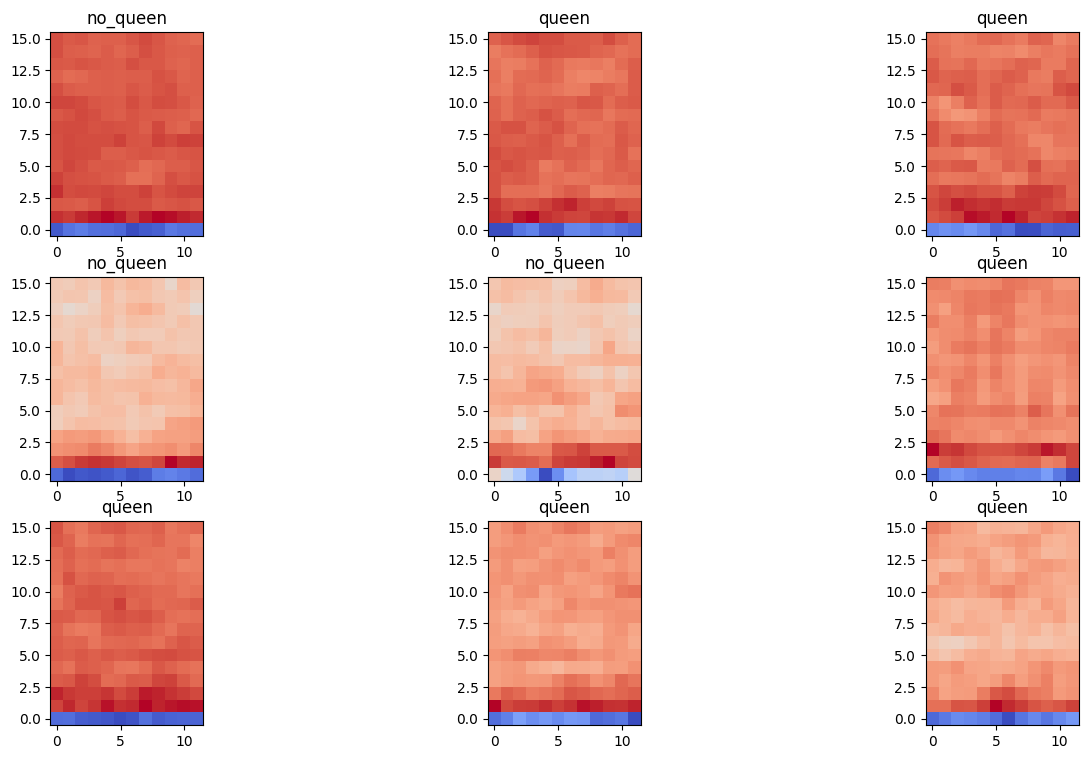

In [3]:
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
plot_mfccs(example_spectrograms, example_spect_labels, label_names)

In [4]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([12, 16, 1])

In [5]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [MFCCs] Sequential model

2024-03-23 14:08:12.201815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2024-03-23 14:08:13.123643: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


22/22 [==============================] - 3s 75ms/step - loss: 0.4675 - accuracy: 0.7825 - val_loss: 0.2255 - val_accuracy: 0.9415
Epoch 2/20
22/22 [==============================] - 0s 11ms/step - loss: 0.2319 - accuracy: 0.9197 - val_loss: 0.2010 - val_accuracy: 0.9591
Epoch 3/20
22/22 [==============================] - 0s 12ms/step - loss: 0.1690 - accuracy: 0.9416 - val_loss: 0.1935 - val_accuracy: 0.9415
Epoch 4/20
22/22 [==============================] - 0s 11ms/step - loss: 0.1138 - accuracy: 0.9606 - val_loss: 0.3272 - val_accuracy: 0.9064
Epoch 5/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0711 - accuracy: 0.9737 - val_loss: 0.2329 - val_accuracy: 0.9415
Epoch 6/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.2486 - val_accuracy: 0.9298
Epoch 7/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0147 - accuracy: 0.9985 - val_loss: 0.2809 - val_accuracy: 0.9240
Epoch 8/20
22/22 [======

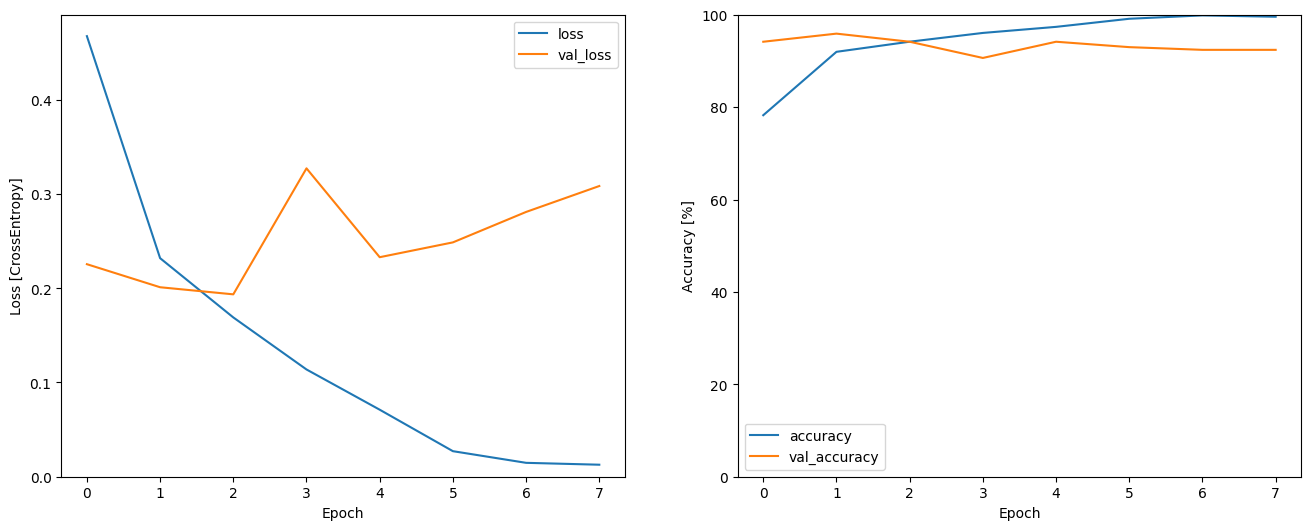

In [6]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [MFCCs] Convolutional model (mini)

Epoch 1/20
22/22 [==============================] - 1s 27ms/step - loss: 0.5872 - accuracy: 0.6832 - val_loss: 0.4893 - val_accuracy: 0.8012
Epoch 2/20
22/22 [==============================] - 0s 6ms/step - loss: 0.4611 - accuracy: 0.8044 - val_loss: 0.3759 - val_accuracy: 0.8713
Epoch 3/20
22/22 [==============================] - 0s 6ms/step - loss: 0.3591 - accuracy: 0.8832 - val_loss: 0.3160 - val_accuracy: 0.8655
Epoch 4/20
22/22 [==============================] - 0s 5ms/step - loss: 0.2936 - accuracy: 0.9066 - val_loss: 0.2623 - val_accuracy: 0.9240
Epoch 5/20
22/22 [==============================] - 0s 5ms/step - loss: 0.2667 - accuracy: 0.9212 - val_loss: 0.2652 - val_accuracy: 0.9064
Epoch 6/20
22/22 [==============================] - 0s 5ms/step - loss: 0.2617 - accuracy: 0.9197 - val_loss: 0.2491 - val_accuracy: 0.9006
Epoch 7/20
22/22 [==============================] - 0s 6ms/step - loss: 0.2465 - accuracy: 0.9139 - val_loss: 0.2207 - val_accuracy: 0.9181
Epoch 8/20
22/22 [=

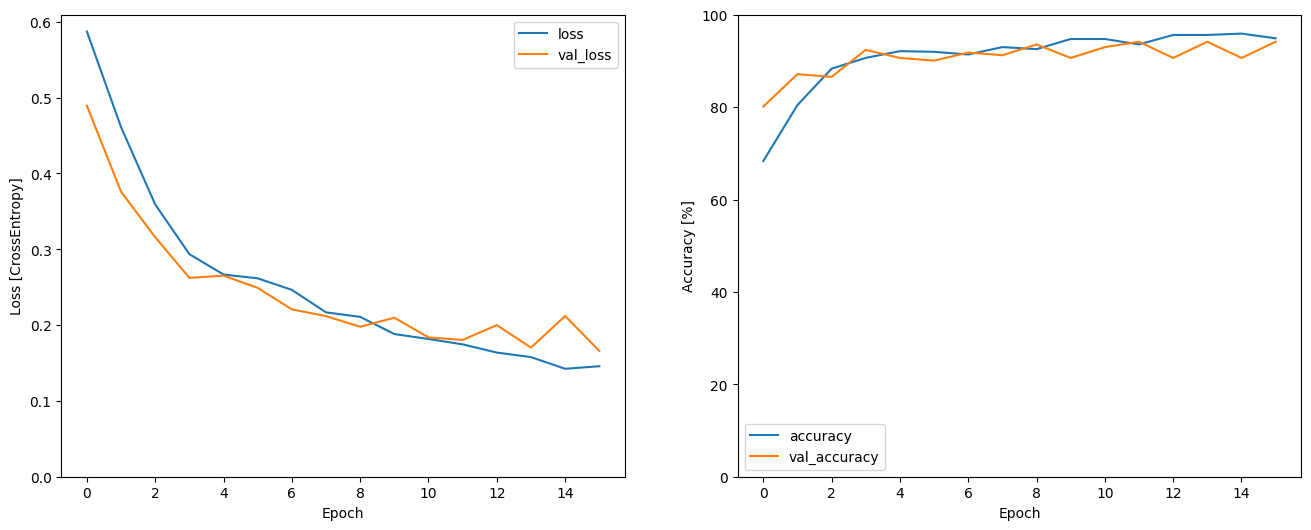

In [7]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Spectrograms

(118, 129, 1)


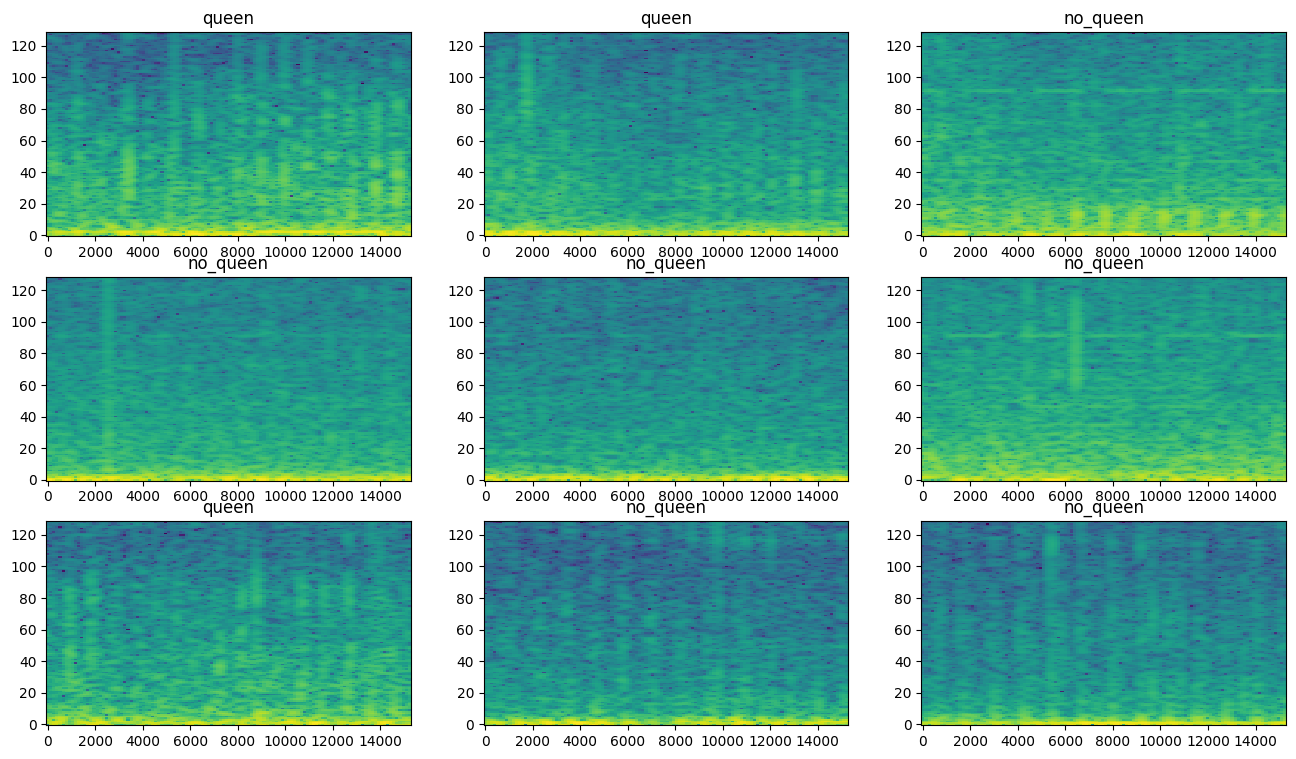

In [8]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [9]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Spec] Sequential model

Epoch 1/60
22/22 [==============================] - 1s 23ms/step - loss: 0.5882 - accuracy: 0.6423 - val_loss: 0.4276 - val_accuracy: 0.8947
Epoch 2/60
22/22 [==============================] - 0s 12ms/step - loss: 0.3422 - accuracy: 0.8453 - val_loss: 0.2173 - val_accuracy: 0.9415
Epoch 3/60
22/22 [==============================] - 0s 11ms/step - loss: 0.1947 - accuracy: 0.9285 - val_loss: 0.1791 - val_accuracy: 0.9649
Epoch 4/60
22/22 [==============================] - 0s 12ms/step - loss: 0.1551 - accuracy: 0.9431 - val_loss: 0.1405 - val_accuracy: 0.9708
Epoch 5/60
22/22 [==============================] - 0s 11ms/step - loss: 0.1324 - accuracy: 0.9577 - val_loss: 0.1468 - val_accuracy: 0.9649
Epoch 6/60
22/22 [==============================] - 0s 12ms/step - loss: 0.1238 - accuracy: 0.9489 - val_loss: 0.1883 - val_accuracy: 0.9591
Epoch 7/60
22/22 [==============================] - 0s 11ms/step - loss: 0.1189 - accuracy: 0.9533 - val_loss: 0.1669 - val_accuracy: 0.9357
Epoch 8/60
22

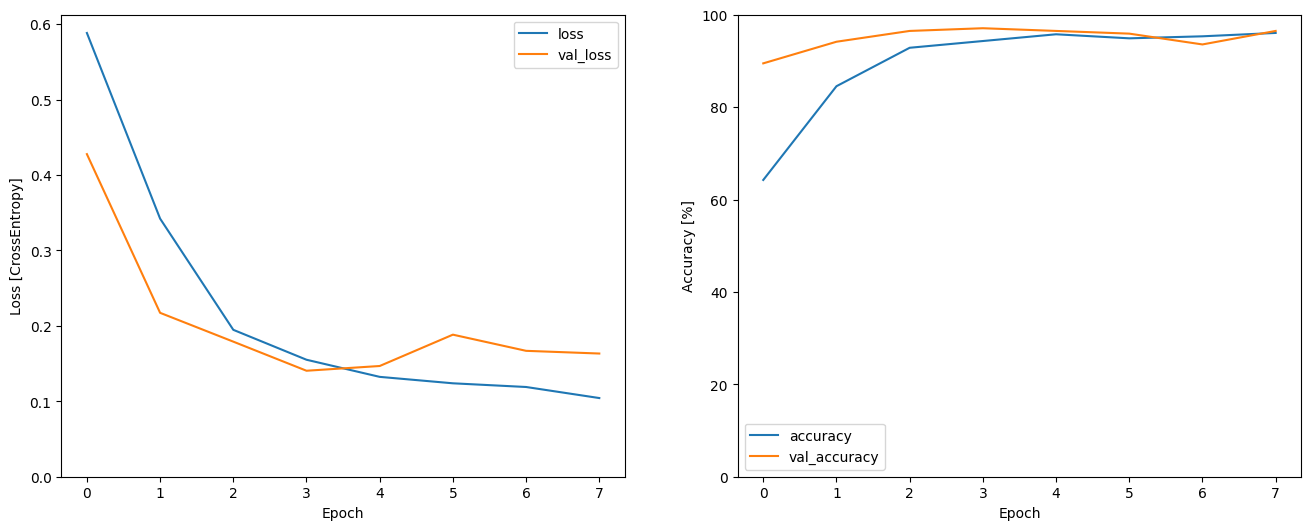

In [10]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=60,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Spec] Convolutional model

Epoch 1/50
22/22 [==============================] - 2s 31ms/step - loss: 0.7429 - accuracy: 0.4993 - val_loss: 0.7067 - val_accuracy: 0.6140
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.6094 - accuracy: 0.6190 - val_loss: 0.5646 - val_accuracy: 0.6901
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.5111 - accuracy: 0.7620 - val_loss: 0.4408 - val_accuracy: 0.8304
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 0.3861 - accuracy: 0.8496 - val_loss: 0.3233 - val_accuracy: 0.8830
Epoch 5/50
22/22 [==============================] - 0s 18ms/step - loss: 0.3194 - accuracy: 0.8715 - val_loss: 0.2539 - val_accuracy: 0.9240
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.2536 - accuracy: 0.9022 - val_loss: 0.2075 - val_accuracy: 0.9532
Epoch 7/50
22/22 [==============================] - 0s 14ms/step - loss: 0.2106 - accuracy: 0.9226 - val_loss: 0.1837 - val_accuracy: 0.9532
Epoch 8/50
22

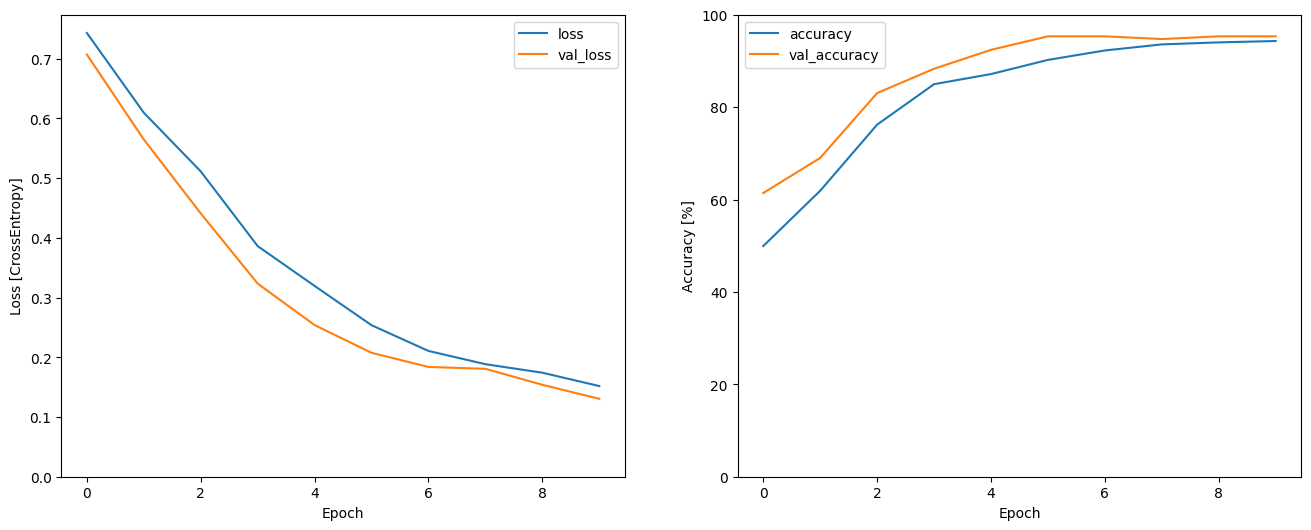

In [11]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=50,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Save models

In [12]:
model_mfcc_seq.save('models/mfcc_seq.h5')
model_mfcc_conv.save('models/mfcc_conv_mini.h5')
model_spec_seq.save('models/spec_seq.h5')
model_spec_conv.save('models/spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
